analysing the vocabulary of texts at individual word level. see below for word frequency clouds (and numerical counts), TF-IDF scores, and bigrams, all generated from the cleaneds of our EP tuning set :)))

In [2]:
# ha ha importing + methods

from collections import Counter
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
import pandas as pd
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk import ngrams 
from gensim.utils import simple_preprocess
from gensim.models import Phrases
from operator import itemgetter

stop_words = stopwords.words('english')

def remove_stopwords(data):
    stop_words.extend(['thus', 'thereof', 'thence', 'thee', 'therein', 
                    'wherein', 'whereby', 'whereas', 'also', 'us', 'upon', 
                    'would', 'within', 'indeed', 'become', 'viz', 'per', 'anno', 
                    'whilst', 'shall','may','unto','say','day','one','make',
                    'two','come','time','place'])
    
    return [[word for word in simple_preprocess(str(doc))
            if word not in stop_words] for doc in data]

In [6]:
#tf-idf set up
texts = []
textnames = []
folder = '/srv/data/newEPTuningClean'
for file in os.listdir(folder):
    path = os.path.join(folder,file)
    f = open(path,'r')
    data = f.readlines()[0]
    texts.append(data)
    name = file.split('.')[0]
    textnames.append(name)
    f.close()
 
# list of lists of strings, each text broken up into individual token strings
tokenized = []
# list of strings, each text as confinuous string of tokens
corpus = []
for text in texts:
    words = []
    text = text.split(' ')
    #tokenize roughly by white space, can update later
    cleaned = remove_stopwords(text)
    for c in cleaned:
        if len(c) != 0:
            words.append(c[0].lower())
    #TODO: smarter way of getting a list of words while still using remove method?
    tokenized.append(words)
    corpus.append(' '.join(words))

wordcounts = [Counter(t) for t in tokenized]
df = pd.DataFrame(wordcounts, index=[name for name in textnames]).fillna(0)

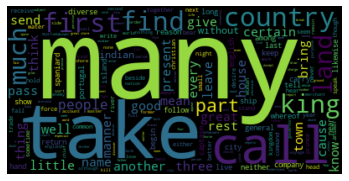

word frequencies: [('many', 7336), ('take', 7213), ('call', 7068), ('country', 5993), ('first', 5944), ('find', 5936), ('land', 5731), ('king', 5648), ('much', 5369), ('part', 5308), ('people', 5066), ('good', 4725), ('great', 4654), ('give', 4537), ('present', 4447), ('another', 4341), ('bring', 4277), ('thing', 4190), ('cause', 4109), ('know', 4021), ('three', 3789), ('every', 3759), ('little', 3687), ('leave', 3669), ('certain', 3645), ('pass', 3520), ('mean', 3485), ('send', 3472), ('house', 3438), ('name', 3428), ('rest', 3413), ('think', 3402), ('manner', 3368), ('well', 3350), ('town', 3248), ('without', 3229), ('indian', 3112), ('company', 3105), ('return', 3070), ('long', 3027)]
relative frequencies: [('many', 1.0), ('take', 0.9832333696837514), ('call', 0.9634678298800436), ('country', 0.8169302071973827), ('first', 0.8102508178844057), ('find', 0.8091603053435115), ('land', 0.781215921483097), ('king', 0.7699018538713195), ('much', 0.7318702290076335), ('part', 0.72355507088

In [16]:
#term frequency & word clouds through wordcloud library processing

#use this for specific text
# fileTF = input("Input the TCP ID of the file here:")
# fileTF = "A01932"
# textstring = ' '.join(tokenized[textnames.index(fileTF)]).lower()

#use this for a chunk of texts
wholecorpusstring = ' '.join(corpus)

# parameters to play with: min_word_length, collocations, collocation_threshold, stopwards

#single text
#wordcloud = WordCloud(stopwords=STOPWORDS, collocations=True, min_word_length=3).generate(textstring)
#corpus
wordcloud = WordCloud(stopwords=STOPWORDS, collocations=True, collocation_threshold=20, min_word_length=4).generate(wholecorpusstring)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

#single text
#textdict = wordcloud.process_text(textstring)
#corpus
textdict = wordcloud.process_text(wholecorpusstring)

wordfreq={k: v for k, v in sorted(textdict.items(),reverse=True, key=lambda item: item[1])}
relfreq=wordcloud.words_

# printing top 40 words and frequency + relative freq
N=40

print("word frequencies:", list(wordfreq.items())[:N])
print("relative frequencies:", list(relfreq.items())[:N])


In [10]:
# setting up manual term frequency

count = CountVectorizer(ngram_range=(1,3))
X = count.fit_transform(corpus)
X = X.toarray()
dataframe = pd.DataFrame(X, index =[name for name in textnames], columns=count.get_feature_names_out())


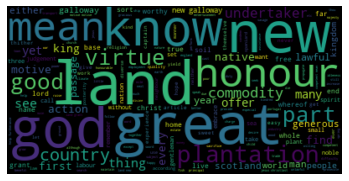

In [11]:
#word cloud generation through term freqs above

topstrings = dataframe.loc['A01932'].sort_values(ascending=False)[:4000]
textdict = dataframe.loc['A01932'].sort_values(ascending=False).to_dict()

wordcloud2 = WordCloud(min_word_length = 3)
wordcloud2.generate_from_frequencies(textdict)

plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis('off')
plt.show()

In [3]:
# basetext = input("input the TCP ID of the text you'd like to sort by: ")
basetext = 'A13290'

In [15]:
# using transformer, generate table to compare tf-idfs across multiple texts
# code accessed from EarlyPrint+Python jupyter notebook

# normalization turned off
# sublinear term frequency scaling turned on (takes log of term frequencies and can help to de-emphasize function words like pronouns and articles.
tfidf = TfidfTransformer(norm=None, sublinear_tf=True)
results = tfidf.fit_transform(df)

table = pd.DataFrame(results.toarray(), index=df.index, columns=df.columns)

# columns are texts
# use .head(30) to show only the top 30 terms
# sort using words with highest tfidf scores in A01932 as an example
table.T.sort_values(by=[basetext], ascending=False).head(25)

,A01932,A02495,A03149,A04813,A07886,A10821,A12458,A12460,A12466,A13290,...,A66847,A68617,A69149,A71305,A71306,A71307,A77422,A83297,B00052,B00963
trinidado,0.0,0.000000,2.686399,12.313160,0.0,4.548469,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,7.913890,0.000000,0.0,0.0,0.0,0.0
berreo,0.0,16.559219,0.000000,12.156225,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,2.909543,0.000000,0.0,0.0,0.0,0.0
raleana,0.0,12.438392,0.000000,11.855469,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
carapana,0.0,13.919803,0.000000,11.319202,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,6.106002,0.000000,0.0,0.0,0.0,0.0
marguerita,0.0,0.000000,0.000000,10.057843,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
carib,0.0,0.000000,0.000000,10.057843,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
oreliano,0.0,0.000000,0.000000,10.057843,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
topiawarie,0.0,7.629519,0.000000,9.845666,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
guiana,0.0,12.961344,5.007907,9.619029,0.0,4.404174,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,2.098612,10.308432,0.000000,0.0,0.0,0.0,0.0
iaos,0.0,0.000000,0.000000,9.400995,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0


In [14]:
# transformer version, but outputting tf-idf values for a single text, easier viewing

transformer = TfidfTransformer(norm=None, sublinear_tf=True, use_idf=True)
cv = CountVectorizer()
wc = cv.fit_transform(corpus)
wctrans = transformer.fit_transform(wc)

single = pd.DataFrame(wctrans[textnames.index(basetext)].T.todense(), index=cv.get_feature_names_out(), columns=[basetext + " TF-IDF"])
single = single.sort_values(basetext + ' TF-IDF', ascending=False)

print (single.head(25))

              A03149 TF-IDF
boterus           16.088661
gules             14.827404
sleid             14.738756
brandenbourg      14.015802
lorreine          14.015802
guicciard         13.358954
rodolphus         13.358954
savus             13.110394
sleidan           13.110394
munster           13.106608
bara              13.082780
alphonso          12.912613
pyrenean          12.843406
adrianus          12.775253
antigonus         12.775253
camden            12.662535
saxony            12.628191
genoy             12.555037
paradin           12.555037
grimston          12.438392
frederick         12.399779
capet             12.241562
luxenbourg        12.241562
catelogne         12.241562
macrinus          12.241562


In [7]:
#generating some bi- and tri-grams

textindex = textnames.index(basetext)

bigram = Phrases(tokenized, min_count = 3, threshold=10)

# print bigrams!
for b in bigram[tokenized[textindex]]:
    if '_' in b:
        print(b)

# n = 2
# ngramcounts = Counter(ngrams(tokenized[textindex], n))
# print(ngramcounts.most_common(10))

sermon_preach
adventurer_planter
thou_thy
thou_thou
thou_thy
bless_bless
curse_curse
thou_thou
heaven_earth
plant_herb
male_female
jesus_christ
bring_forth
fill_earth
scatter_abroad
son_noah
fill_earth
induce_thereunto
whence_whither
pleasant_fruitful
leave_behind
promise_abram
builder_babel
god_bless
builder_babel
replenish_earth
builder_babel
blessing_blessing
bestow_blessing
temporal_estate
temporal_estate
bless_bless
curse_curse
curse_curse
jesus_christ
bless_sense
dream_vision
ordinary_extraordinary
often_repeat
spread_abroad
replenish_earth
garden_eden
noah_flood
bring_forth
replenish_earth
dream_vision
replenish_earth
four_hundred
inheritance_father
among_gentile
father_mother
spread_abroad
roman_colony
herb_tree
fish_fowl
god_praise
pray_god
abraham_posterity
providence_god
monarch_world
fill_earth
gog_magog
christ_saviour
fill_earth
father_son
holy_ghost
propagation_gospel
never_hear
go_abroad
lord_host
thanks_god
lord_host
rule_govern
answer_objection
invade_territory
sigismo